<a href="https://colab.research.google.com/github/parthd2804/Health-Informatics-CRC-Screening-Analysis/blob/main/IS460_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Block 1 – Import libraries & load the data

In this block we load the HINTS 6 dataset and import Python libraries. This is the first step of the health data pipeline (data → information).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

df = pd.read_csv(
    "/hints6_public.csv",
    engine="python",
    on_bad_lines="skip"
)

df.head()



,HHID,APP_REGION,DRA,Treatment_H6,RUC2003,RUC2013,PR_RUCA_2010,NCHSURCODE2013,CENSDIV,CENSREG,...,smokeStat,PHQ4,WeeklyMinutesModerateExercise,eCigUse,AvgDrinksPerWeek,PCCScale,ISEE_Scale,PROMIS_Isolation_t,PROMIS_Meaning_t,IncomeRanges_IMP
0,21000006,Non-Appalachia,Not in the Mississippi Delta region,Concurrent mixed-mode,County in metro area with 1 million population...,Metro - Counties in metro areas of 1 million p...,Metropolitan,Metropolitan: large fringe metro,South Atlantic,South,...,Former,0,0,Never,0,100,"Inapplicable, coded 2 in SeekCancerInfo",34.8,65.5,"$0 to $9,999"
1,21000009,Non-Appalachia,Not in the Mississippi Delta region,Concurrent mixed-mode,"County in metro area of 250,000 to 1 million p...","Metro - Counties in metro areas of 250,000 to ...",Metropolitan,Metropolitan: medium metro,East North Central,Midwest,...,Never,8,420,Never,35,100,"Inapplicable, coded 2 in SeekCancerInfo",53.9,41.7,"$50,000 to $74,999"
2,21000020,Non-Appalachia,Not in the Mississippi Delta region,Concurrent mixed-mode,County in metro area with 1 million population...,Metro - Counties in metro areas of 1 million p...,Metropolitan,Metropolitan: large metro,Middle Atlantic,Northeast,...,Missing data (Web partial - Question Never Seen),Missing data (Web partial - Question Never Seen),Missing data (Web partial - Question Never Seen),Missing data (Web partial - Question Never Seen),Missing data (Web partial - Question Never Seen),100,50,Missing data (Web partial - Question Never Seen),Missing data (Web partial - Question Never Seen),"$0 to $9,999"
3,21000022,Non-Appalachia,Not in the Mississippi Delta region,Concurrent mixed-mode,County in metro area with 1 million population...,Metro - Counties in metro areas of 1 million p...,Metropolitan,Metropolitan: large fringe metro,Middle Atlantic,Northeast,...,Never,0,0,Never,0,90.5,"Inapplicable, coded 2 in SeekCancerInfo",34.8,56.5,"$35,000 to $49,999"
4,21000039,Non-Appalachia,Not in the Mississippi Delta region,Concurrent mixed-mode,County in metro area with 1 million population...,Metro - Counties in metro areas of 1 million p...,Metropolitan,Metropolitan: large fringe metro,South Atlantic,South,...,Never,6,10,Never,0,57.1,"Inapplicable, coded 2 in SeekCancerInfo",34.8,53.5,"$50,000 to $74,999"



### Block 2 – Select variables & create the screening outcome

In this block, we keep only the variables needed for our analysis (provider communication, interest in screening, age, gender, and education). We then create a simple outcome variable called **CRC_upToDate**, which tells us whether a person is up-to-date with cancer screening.

This step is related to our IS460 syllabus because it shows how raw health survey data is transformed into **meaningful indicators** used in **public health informatics** and **clinical decision-making**. Health informatics systems often turn detailed survey or EHR data into simple “yes/no” flags that support prevention, screening reminders, and population health dashboards.


In [ ]:
cols_needed = [
    "InterestedCaScreening",
    "ExplainedClearly",
    "ChanceAskQuestions",
    "DocTellColorectalTests",
    "AgeGrpA",
    "BirthGender",
    "Education"
]

data = df[cols_needed].copy()


data["CRC_upToDate"] = np.where(
    data["InterestedCaScreening"] == "Not applicable/I am up-to-date with screening tests",
    1,
    0
)


print("Value counts for CRC_upToDate (0 = not up-to-date, 1 = up-to-date):")
print(data["CRC_upToDate"].value_counts())
print("\nPercentages:")
print(data["CRC_upToDate"].value_counts(normalize=True) * 100)

data.head()


Value counts for CRC_upToDate (0 = not up-to-date, 1 = up-to-date):
CRC_upToDate
0    5156
1    1096
Name: count, dtype: int64

Percentages:
CRC_upToDate
0    82.46961
1    17.53039
Name: proportion, dtype: float64


,InterestedCaScreening,ExplainedClearly,ChanceAskQuestions,DocTellColorectalTests,AgeGrpA,BirthGender,Education,CRC_upToDate
0,Very,Always,Always,Missing data (Not Ascertained),45+,Male,Less than 8 years,0
1,Not at all,Always,Always,Yes,45+,Male,College graduate,0
2,Missing data (Web partial - Question Never Seen),Always,Always,Missing data (Web partial - Question Never Seen),40-44,Missing data (Web partial - Question Never Seen),Missing data (Web partial - Question Never Seen),0
3,Not at all,Always,Always,Yes,45+,Male,12 years or completed high school,0
4,Very,Usually,Always,I have never discussed these tests with a doct...,35-39,Female,College graduate,0


### Block 3 – Recode provider–patient communication

In this block, we turn the detailed communication answers into simple indicators:

- **ExplainedClearly_bin** = 1 if the provider *always/usually* explained things clearly, 0 if *sometimes/never*.
- **ChanceAskQuestions_bin** = 1 if the patient *always/usually* had a chance to ask questions, 0 if *sometimes/never*.
- **DocToldCRC** = 1 if a doctor ever told the person they should get colorectal cancer screening, 0 otherwise.

This connects to our IS460 syllabus because we are converting patient–provider communication data into **clear, measurable variables** that can be used in **clinical and consumer health informatics** to evaluate communication quality and its impact on preventive care.


In [ ]:

def recode_comm(series):
    good = ["Always", "Usually"]
    poor = ["Sometimes", "Never"]

    out = series.copy()
    out = out.replace({
        **{g: 1 for g in good},
        **{p: 0 for p in poor}
    })

    out = out.where(out.isin([0, 1]), np.nan)
    return out

data["ExplainedClearly_bin"] = recode_comm(data["ExplainedClearly"])

data["ChanceAskQuestions_bin"] = recode_comm(data["ChanceAskQuestions"])

data["DocToldCRC"] = data["DocTellColorectalTests"].replace({
    "Yes": 1,
    "No": 0,
    "I have never discussed these tests with a doctor or other he": 0
})
data["DocToldCRC"] = data["DocToldCRC"].where(data["DocToldCRC"].isin([0, 1]), np.nan)

print("ExplainedClearly_bin:")
print(data["ExplainedClearly_bin"].value_counts(dropna=False), "\n")

print("ChanceAskQuestions_bin:")
print(data["ChanceAskQuestions_bin"].value_counts(dropna=False), "\n")

print("DocToldCRC:")
print(data["DocToldCRC"].value_counts(dropna=False))


ExplainedClearly_bin:
ExplainedClearly_bin
1      4934
NaN     817
0       501
Name: count, dtype: int64 

ChanceAskQuestions_bin:
ChanceAskQuestions_bin
1      4870
NaN     807
0       575
Name: count, dtype: int64 

DocToldCRC:
DocToldCRC
1      3011
0      2787
NaN     454
Name: count, dtype: int64


### Block 4 – Create the cleaned analysis dataset

Here we build **analysis_df**, which only keeps respondents who have complete data on:

- Screening status (CRC_upToDate)
- Provider communication (ExplainedClearly, ChanceAskQuestions, DocToldCRC)
- Demographics (AgeGrpA, BirthGender, Education)

This step is related to our IS460 syllabus topic of **data quality and preparation in health informatics**. Real-world health data often have missing values, so we need a cleaned dataset before creating dashboards, doing statistical tests, or building decision-support tools.


In [ ]:
analysis_df = data.dropna(subset=[
    "CRC_upToDate",
    "ExplainedClearly_bin",
    "ChanceAskQuestions_bin",
    "DocToldCRC",
    "AgeGrpA",
    "BirthGender",
    "Education"
]).copy()

print("Number of respondents with complete data:", len(analysis_df))

print("\nAge group:")
print(analysis_df["AgeGrpA"].value_counts())

print("\nBirth gender:")
print(analysis_df["BirthGender"].value_counts())

print("\nEducation:")
print(analysis_df["Education"].value_counts())


Number of respondents with complete data: 5100

Age group:
AgeGrpA
45+                                             3699
18-34                                            688
35-39                                            339
40-44                                            315
Missing Data (Not Ascertained)                    58
Unreadable or Nonconforming Numeric Response       1
Name: count, dtype: int64

Birth gender:
BirthGender
Female                                              3095
Male                                                1940
Missing data (Not Ascertained)                        41
Missing data (Web partial - Question Never Seen)      23
Multiple responses selected in error                   1
Name: count, dtype: int64

Education:
Education
College graduate                                                1424
Some college                                                    1076
Postgraduate                                                    1013
12 years or completed 

### Block 5 – Descriptive results and visualizations

In this block we create simple bar charts to show:

- The overall percentage of people who are **up-to-date with screening**.
- How up-to-date screening varies by:
  - Whether providers **explained things clearly**.
  - Whether patients had a **chance to ask questions**.
  - Different **age groups**, combined with clear explanations.

These visuals connect directly to our IS460 topics on **health data visualization and dashboards**. They show how provider–patient communication and demographics can be turned into easy-to-read charts that support **public health** and **clinical decision-making** (for example, identifying groups with lower screening rates who might benefit from better communication or outreach).


5.1 Overall “up-to-date with screening” rate

Percent up-to-date vs not up-to-date:
CRC_upToDate
0    80.588235
1    19.411765
Name: proportion, dtype: float64


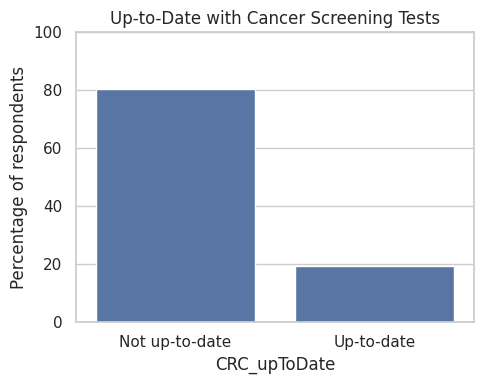

In [ ]:

screen_counts = analysis_df["CRC_upToDate"].value_counts(normalize=True) * 100
print("Percent up-to-date vs not up-to-date:")
print(screen_counts)

plt.figure(figsize=(5,4))
sns.barplot(
    x=screen_counts.index.map({0: "Not up-to-date", 1: "Up-to-date"}),
    y=screen_counts.values
)
plt.ylabel("Percentage of respondents")
plt.title("Up-to-Date with Cancer Screening Tests")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


5.2 Screening by “ExplainedClearly_bin”

CRC_upToDate                  0          1
ExplainedClearly_bin                      
0                     82.900433  17.099567
1                     80.357913  19.642087


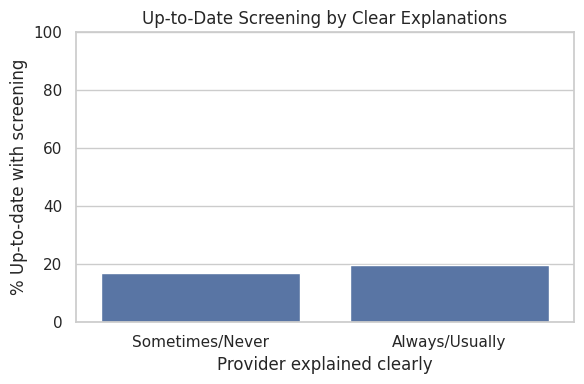

In [ ]:

ct_exp = pd.crosstab(
    analysis_df["ExplainedClearly_bin"],
    analysis_df["CRC_upToDate"],
    normalize="index"
) * 100
print(ct_exp)

plt.figure(figsize=(6,4))
sns.barplot(
    x=ct_exp.index.map({0: "Sometimes/Never", 1: "Always/Usually"}),
    y=ct_exp[1].values
)
plt.ylabel("% Up-to-date with screening")
plt.xlabel("Provider explained clearly")
plt.title("Up-to-Date Screening by Clear Explanations")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


5.3 Screening by “ChanceAskQuestions_bin”

CRC_upToDate                    0          1
ChanceAskQuestions_bin                      
0                       83.458647  16.541353
1                       80.253940  19.746060


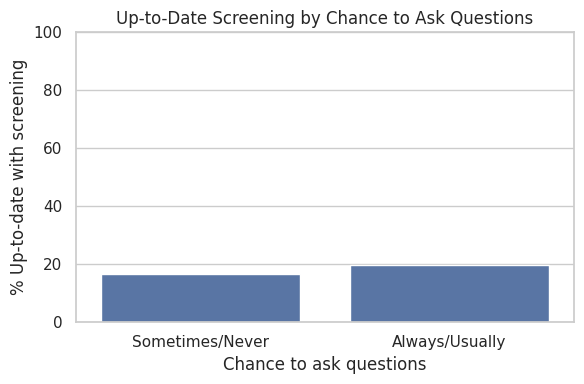

In [ ]:

ct_q = pd.crosstab(
    analysis_df["ChanceAskQuestions_bin"],
    analysis_df["CRC_upToDate"],
    normalize="index"
) * 100
print(ct_q)

plt.figure(figsize=(6,4))
sns.barplot(
    x=ct_q.index.map({0: "Sometimes/Never", 1: "Always/Usually"}),
    y=ct_q[1].values
)
plt.ylabel("% Up-to-date with screening")
plt.xlabel("Chance to ask questions")
plt.title("Up-to-Date Screening by Chance to Ask Questions")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


5.4 Screening by Age group × explanations (nice slide!)

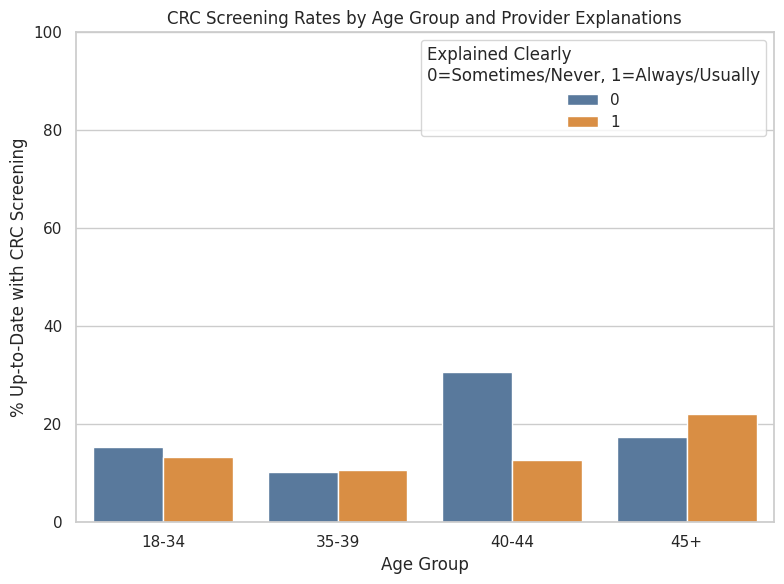

In [ ]:

valid_ages = ["18-34", "35-39", "40-44", "45+"]

cleaned = analysis_df[analysis_df["AgeGrpA"].isin(valid_ages)].copy()

grouped = (
    cleaned
    .groupby(["AgeGrpA", "ExplainedClearly_bin"])["CRC_upToDate"]
    .mean()
    .reset_index()
)

grouped["CRC_upToDate"] *= 100

plt.figure(figsize=(8,6))
sns.barplot(
    data=grouped,
    x="AgeGrpA",
    y="CRC_upToDate",
    hue="ExplainedClearly_bin",
    palette=["#4E79A7", "#F28E2B"]
)

plt.ylabel("% Up-to-Date with CRC Screening")
plt.xlabel("Age Group")
plt.title("CRC Screening Rates by Age Group and Provider Explanations")

plt.ylim(0, 100)
plt.legend(title="Explained Clearly\n0=Sometimes/Never, 1=Always/Usually")

plt.tight_layout()
plt.show()

### Block 6 – Chi-square tests: communication vs screening

In this block, we use chi-square tests to check whether there is a **statistically significant association** between:

- Provider explaining things clearly and being up-to-date with screening  
- Having a chance to ask questions and being up-to-date  
- Being told by a doctor about colorectal cancer tests and being up-to-date

If the p-value is less than 0.05, it suggests that better provider–patient communication is **not just visually different**, but is statistically associated with higher screening rates.

This connects to our IS460 syllabus by showing how **basic statistical methods** in health informatics can be used to evaluate communication quality, support evidence-based practice, and guide public health or clinical interventions.


👉 6.1 Clear explanations vs screening

In [ ]:

ct_exp_raw = pd.crosstab(
    analysis_df["ExplainedClearly_bin"],
    analysis_df["CRC_upToDate"]
)

print("Crosstab: ExplainedClearly_bin vs CRC_upToDate")
print(ct_exp_raw, "\n")

chi2_exp, p_exp, dof_exp, expected_exp = chi2_contingency(ct_exp_raw)

print("Chi-square test – ExplainedClearly vs CRC_upToDate")
print("Chi-square:", round(chi2_exp, 2))
print("Degrees of freedom:", dof_exp)
print("p-value:", p_exp)


Crosstab: ExplainedClearly_bin vs CRC_upToDate
CRC_upToDate             0    1
ExplainedClearly_bin           
0                      383   79
1                     3727  911 

Chi-square test – ExplainedClearly vs CRC_upToDate
Chi-square: 1.58
Degrees of freedom: 1
p-value: 0.20912760581367987


6.2 Chance to ask questions vs screening

In [ ]:

ct_q_raw = pd.crosstab(
    analysis_df["ChanceAskQuestions_bin"],
    analysis_df["CRC_upToDate"]
)

print("Crosstab: ChanceAskQuestions_bin vs CRC_upToDate")
print(ct_q_raw, "\n")

chi2_q, p_q, dof_q, expected_q = chi2_contingency(ct_q_raw)

print("Chi-square test – ChanceAskQuestions vs CRC_upToDate")
print("Chi-square:", round(chi2_q, 2))
print("Degrees of freedom:", dof_q)
print("p-value:", p_q)


Crosstab: ChanceAskQuestions_bin vs CRC_upToDate
CRC_upToDate               0    1
ChanceAskQuestions_bin           
0                        444   88
1                       3666  902 

Chi-square test – ChanceAskQuestions vs CRC_upToDate
Chi-square: 2.93
Degrees of freedom: 1
p-value: 0.08712062794067094


6.3 Doctor told about colorectal tests vs screening

In [ ]:

ct_doc_raw = pd.crosstab(
    analysis_df["DocToldCRC"],
    analysis_df["CRC_upToDate"]
)

print("Crosstab: DocToldCRC vs CRC_upToDate")
print(ct_doc_raw, "\n")

chi2_doc, p_doc, dof_doc, expected_doc = chi2_contingency(ct_doc_raw)

print("Chi-square test – DocToldCRC vs CRC_upToDate")
print("Chi-square:", round(chi2_doc, 2))
print("Degrees of freedom:", dof_doc)
print("p-value:", p_doc)


Crosstab: DocToldCRC vs CRC_upToDate
CRC_upToDate     0    1
DocToldCRC             
0             1961  335
1             2149  655 

Chi-square test – DocToldCRC vs CRC_upToDate
Chi-square: 61.49
Degrees of freedom: 1
p-value: 4.4512714610735845e-15


### Block 7 – Logistic regression: communication and screening

In this block, we run a **logistic regression** model where:

- The outcome is **CRC_upToDate** (1 = up-to-date with screening, 0 = not).
- Predictors include:
  - Provider communication (ExplainedClearly_bin, ChanceAskQuestions_bin, DocToldCRC)
  - Demographics (Age group, birth gender, education).

The model gives us **odds ratios (ORs)**. An OR greater than 1 for a communication variable means that better communication is associated with higher odds of being up-to-date with screening, even after controlling for age, gender, and education.

This connects to our IS460 syllabus by showing how **basic predictive modeling** in health informatics can support:
- Clinical decision support (identifying patients who may need more communication or reminders).
- Public health planning (targeting groups who are less likely to be up-to-date on screening).


Block 7 – Simple logistic regression (with odds ratios)

In [ ]:

model_df = analysis_df.dropna(subset=[
    "CRC_upToDate",
    "ExplainedClearly_bin",
    "ChanceAskQuestions_bin",
    "DocToldCRC",
    "AgeGrpA",
    "BirthGender",
    "Education"
]).copy()

print("Sample size for logistic regression:", len(model_df))

formula = (
    "CRC_upToDate ~ "
    "ExplainedClearly_bin + "
    "ChanceAskQuestions_bin + "
    "DocToldCRC + "
    "C(AgeGrpA) + "
    "C(BirthGender) + "
    "C(Education)"
)

logit_model = smf.logit(formula=formula, data=model_df).fit()
print(logit_model.summary())


Sample size for logistic regression: 5100
         Current function value: 0.481199
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           CRC_upToDate   No. Observations:                 5100
Model:                          Logit   Df Residuals:                     5079
Method:                           MLE   Df Model:                           20
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                 0.02223
Time:                        03:17:40   Log-Likelihood:                -2454.1
converged:                      False   LL-Null:                       -2509.9
Covariance Type:            nonrobust   LLR p-value:                 1.010e-14
                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now convert the coefficients to odds ratios for easier interpretation:

In [ ]:

params = logit_model.params
conf = logit_model.conf_int()

or_table = pd.DataFrame({
    "OR": np.exp(params),
    "CI_lower": np.exp(conf[0]),
    "CI_upper": np.exp(conf[1])
})

or_table.replace([np.inf, -np.inf], np.nan, inplace=True)

or_table

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,OR,CI_lower,CI_upper
Intercept,1.274625e-01,0.087745,0.185159
ExplainedClearly_bin[T.1],1.026741e+00,0.764948,1.378129
ChanceAskQuestions_bin[T.1],1.136714e+00,0.860207,1.502101
DocToldCRC[T.1],1.563052e+00,1.330297,1.836533
C(AgeGrpA)[T.35-39],7.343910e-01,0.487192,1.107017
C(AgeGrpA)[T.40-44],1.000837e+00,0.680189,1.472642
C(AgeGrpA)[T.45+],1.386164e+00,1.079311,1.780256
C(AgeGrpA)[T.Missing Data (Not Ascertained)],1.130346e+00,0.484996,2.634419
C(AgeGrpA)[T.Unreadable or Nonconforming Numeric Response],3.729953e-11,0.000000,NaN
C(BirthGender)[T.Male],7.394533e-01,0.637144,0.858191


from matplotlib import pyplot as plt
or_table['OR'].plot(kind='hist', bins=20, title='OR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
or_table['CI_lower'].plot(kind='hist', bins=20, title='CI_lower')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
or_table['CI_upper'].plot(kind='hist', bins=20, title='CI_upper')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
or_table.plot(kind='scatter', x='OR', y='CI_lower', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
or_table.plot(kind='scatter', x='CI_lower', y='CI_upper', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
or_table['OR'].plot(kind='line', figsize=(8, 4), title='OR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
or_table['CI_lower'].plot(kind='line', figsize=(8, 4), title='CI_lower')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
or_table['CI_upper'].plot(kind='line', figsize=(8, 4), title='CI_upper')
plt.gca().spines[['top', 'right']].set_visible(False)

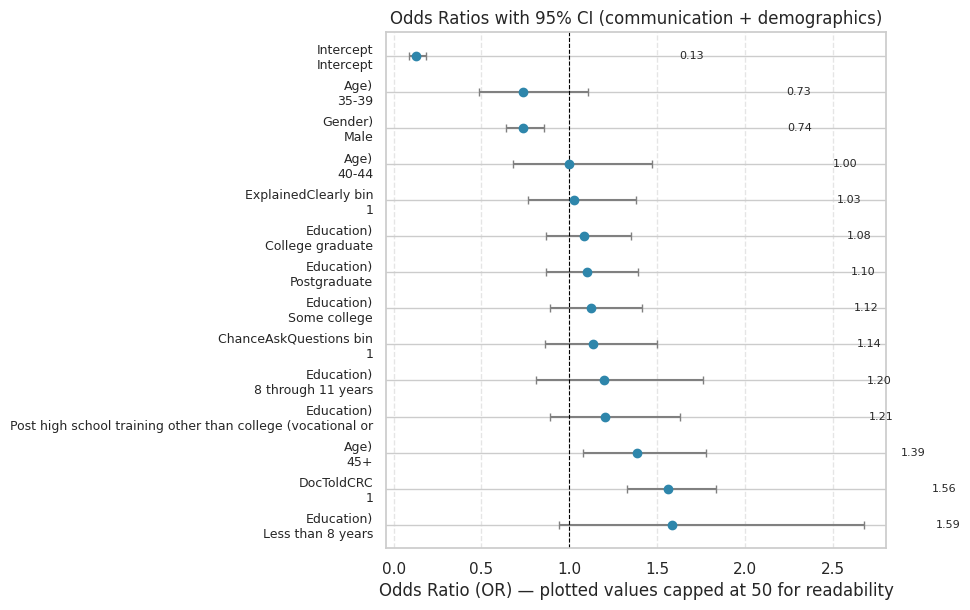

In [ ]:
import re
import textwrap
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.family":"sans-serif"})

plot_df = or_table.copy().replace([np.inf, -np.inf], np.nan)


remove_patterns = [
    r"Unreadable", r"Nonconforming", r"Multiple responses",
    r"Web partial", r"Question Never Seen", r"Missing data", r"Not Ascertained"
]
mask_bad = plot_df.index.to_series().astype(str).str.contains("|".join(remove_patterns), regex=True, na=False)
plot_df_plot = plot_df[~mask_bad].copy()

def make_short_label(full_index, width=20):
    s = str(full_index)
    s = re.sub(r"^C\(|\)$", "", s)
    s = s.replace("T.", "")
    s = s.replace("BirthGender", "Gender")
    s = s.replace("AgeGrpA", "Age")
    s = s.replace("Education", "Education")
    s = s.replace("DocToldCRC", "DocToldCRC")
    m = re.search(r"\[?([^\[\]]+)\]?$", s)
    if m:
        cat = m.group(1)
        cat = cat.replace("Missing data (Not Ascertained)", "Missing")
        cat = cat.replace("Not ascertained", "Missing")
        cat = cat.replace("I have never discussed these tests with a doctor or other he", "Never discussed")
        cat = cat.replace("T.", "")
        base = re.sub(r"[\[\(].*?$", "", s).strip()
        short = f"{base}\n{cat}"
    else:
        short = "\n".join(textwrap.wrap(s, width=20))
    short = short.replace("_", " ").replace("  ", " ").strip()
    return short

plot_df_plot["label_short"] = [make_short_label(i, width=20) for i in plot_df_plot.index]

plot_df_plot = plot_df_plot.sort_values(by="OR", ascending=True).dropna(subset=["OR"])

fig_height = max(6, 0.28 * len(plot_df_plot))
fig, ax = plt.subplots(figsize=(10, fig_height))

y = np.arange(len(plot_df_plot))
or_vals = plot_df_plot["OR"].values
ci_low = plot_df_plot["CI_lower"].values
ci_up = plot_df_plot["CI_upper"].values

left_err = or_vals - ci_low
right_err = ci_up - or_vals
left_err = np.where(np.isnan(left_err), 0, left_err)
right_err = np.where(np.isnan(right_err), 0, right_err)

plot_cap = 50.0
or_plot_vals = np.clip(or_vals, a_min=0, a_max=plot_cap)
left_err_plot = np.minimum(left_err, or_plot_vals)
right_err_plot = np.minimum(right_err, plot_cap - or_plot_vals + 1e-9)

ax.errorbar(or_plot_vals, y, xerr=[left_err_plot, right_err_plot],
            fmt='o', ecolor='gray', capsize=3, color='#2E86AB', markersize=6)

ax.axvline(1.0, color='black', linestyle='--', linewidth=0.8)

ax.set_yticks(y)
ax.set_yticklabels(plot_df_plot["label_short"].tolist(), fontsize=9)
ax.invert_yaxis()

ax.set_xlabel("Odds Ratio (OR) — plotted values capped at {:.0f} for readability".format(plot_cap))
ax.set_title("Odds Ratios with 95% CI (communication + demographics)")

plt.subplots_adjust(left=0.45, right=0.95, top=0.92, bottom=0.06)

for xi, yi, actual in zip(or_plot_vals, y, plot_df_plot["OR"].values):
    if not (np.isnan(actual) or np.isinf(actual)):
        txt = f"{actual:.2f}"
        ax.text(min(plot_cap*0.98, xi + 0.03*plot_cap), yi, txt, va='center', fontsize=8)

ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()